# TP à rendre 4 descripteurs d'images
Dans ce TP, nous aimerions appliquer une analyse d'image en extrayant les points clés d'une image donnée.
L'objectif de la detection de points d'interet est d'initier des traitement ultérieurs tel que la comparaison d'images entres elles.

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from numpy import linalg as LA
import math

from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/TAIV/TP4/'

Mounted at /content/drive


In [2]:
#lecture de l'image
image =cv.imread(path+'image2.png',0)

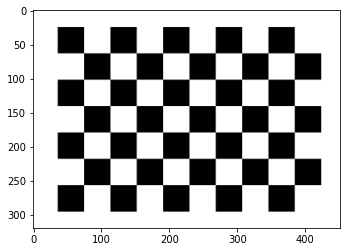

In [ ]:
plt.imshow(image,cmap='gray')

# Detection de points avec le detecteur MORAVEC

Définition de paramètres

In [ ]:
# paramétres de MORAVEC
S= 2  # Seuil
F= 3  # Taille de la fenêtre
U= [[1,0],[1,1],[0,1],[-1,1],[-1,0],[-1,-1],[0,-1],[1,-1]]# Déplacements

Calcul de la carte de coins (cornerness map)

In [ ]:
def cornerness(map, x, y):
  browse = []
  for i in range(math.ceil(-F / 2), math.ceil(F / 2)):
    for j in range(math.ceil(-F / 2), math.ceil(F / 2)):
      browse.append((i, j))
  V = []
  for i,j in U:
    temp = 0
    for k, l in browse: temp += (map[x+k][y+l] - map[x+k+i][y+l+j]) ** 2
    V.append(temp)
  return V

def cornerness_map(map):
  height = map.shape[0]
  width = map.shape[1]
  map = cv.copyMakeBorder(map, F // 2, F // 2, F // 2, F // 2, cv.BORDER_CONSTANT, None, value=0)
  c_map = []
  for i in range(height):
    c_map.append([])
    for j in range(width):
      c_map[i].append(cornerness(map, i, j))
  return c_map

Minimum de la carte de coins

In [ ]:
def min_corner(map):
  c_map = []
  for i in range(len(map)):
    c_map.append([])
    for j in range(len(map[1])):
      c_map[i].append(min(map[i][j]))
  return c_map

Appel des fonctions pour calcul de points d'interêt

In [ ]:
moravec = min_corner(cornerness_map(image))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in ubyte_scalars
  if __name__ == '__main__':


Affichage de l'image résultante, colorer chaque point d'interêt

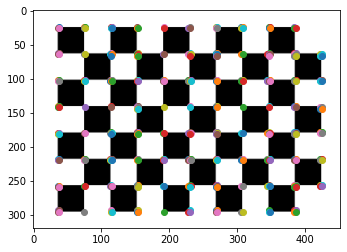

In [ ]:
plt.imshow(image, cmap='gray', zorder=1)
for i in range(0, len(moravec), 2):
  for j in range(0, len(moravec[1]), 2):
    if moravec[i][j] >= S:
      plt.scatter(j, i, zorder=2)
plt.show()

# Descripteurs Harris
D'abord calculer les valeurs et vecteurs propres comme vu en TD, puis appliquer l'agorithme de Harris

In [ ]:
A= [[-1,2,0],[0,3,4],[0,0,7]]
B=[[-1,2,2],[2,2,-1],[1,-2,1]]
val1, vec1 = LA.eig(A)
val2, vec2 = LA.eig(B)

In [ ]:
print(val1,'\n', vec1,'\n',val2,'\n',vec2)

[-1.  3.  7.] 
 [[1.         0.4472136  0.17407766]
 [0.         0.89442719 0.69631062]
 [0.         0.         0.69631062]] 
 [-3.  2.  3.] 
 [[-8.16496581e-01  4.36435780e-01 -7.02166694e-17]
 [ 4.08248290e-01 -2.18217890e-01 -7.07106781e-01]
 [ 4.08248290e-01  8.72871561e-01  7.07106781e-01]]


Expliquer le résultat obtenu, et comparer avec le TD;  
Pourquoi les résultats sont-ils différents?

# Reponse:
The content of val1 and val2 corresponds to the lambdas (eigenvalues / valeurs propres) of A and B respectively, and vec1 and vec2 correspond to the eigenvectors (vecteurs propres) of A and B respectively, where the first eigenvalue of val1 corresponds to the first column of vec1, the second value of val1 to the second column of vec1, and so on.
The function LA.eig() also assigns a value to the t in the eigenvectors, so if we compare the second eigenvector of A (from the TD series) which was t[1/2, 1, 0] to the result of the function which was [0.44, 0.89, 0], they may seem to be different at first glance, but if we to extract t as a common factor, we'll end up with the same result as the TD: t[1/2, 1, 0] with t = 0.89

# Detection de points avec HARRIS
- appliquer les étapes vues en TD
- pour chaque point (x,y) de l'image, determiner si c'est un point d'interêt ou pas en prennant une fenêtre 3x3 entourant x,y

In [45]:
seuil = 100000000
def harris(img, S, sigma):
  #result = cv.cvtColor(img.copy(), cv.COLOR_GRAY2BGR)

  height = img.shape[0] 
  width = img.shape[1]

  result = np.zeros((height, width))

  gx = np.zeros((height, width))
  gy = np.zeros((height, width))

  matrix = cv.copyMakeBorder(img.copy(), 1, 1, 1, 1, cv.BORDER_CONSTANT, None, value=0)
  matrix = matrix.astype('int32')

  for i in range(1, height+1):
    for j in range(1, width+1):
      gx[i-1][j-1] = matrix[i+1][j] - matrix[i][j]
      gy[i-1][j-1] = matrix[i][j+1] - matrix[i][j]

  ix2 = np.square(gx)
  iy2 = np.square(gy)
  ixy = gx * gy

  ix2 = cv.GaussianBlur(ix2, (3, 3), sigma)
  iy2 = cv.GaussianBlur(iy2, (3, 3), sigma)
  ixy = cv.GaussianBlur(ixy, (3, 3), sigma)

  
  for i in range(0, height, 3):
    for j in range(0, width, 3):
      M = [[],[]]
      M[0].append(np.sum(ix2[i:(i+3),j:(j+3)]))
      M[0].append(np.sum(ixy[i:(i+3),j:(j+3)]))
      M[1].append(np.sum(ixy[i:(i+3),j:(j+3)]))
      M[1].append(np.sum(iy2[i:(i+3),j:(j+3)]))

      # using Szeliski method
      val, _ = LA.eig(M)
      alpha = 0.06
      R = val[0] * val[1] - alpha * ((val[0] + val[1]) ** 2)
      if R > S: result[i+1][j+1] = 255
      #if ((val[0] * val[1]) / (val[0] + val[1])) >= S: result[i+1][j+1] = 255
      #if ((val[0] * val[1]) / (val[0] + val[1])) >= S: cv.circle(result,((j+1), (i+1)), 3, (0, 255, 0))
  
  #plt.imshow(result)
  
  # used only for the comparison in the last section
  plt.subplot(1, 2, 1)
  result = cv.dilate(result, None)
  img2 = np.zeros((img.shape[0], img.shape[1], 3))
  img2[:, :, 0] = img
  img2[:, :, 1] = img
  img2[:, :, 2] = img
  img2[result > 0.01 * result.max()]=[255, 0, 0]
  plt.title("our method")
  plt.imshow(img2)

  plt.subplot(1, 2, 2)
  dst = cv.cornerHarris(img,2,3,0.06)
  dst = cv.dilate(dst, None)
  img2=np.zeros((img.shape[0],img.shape[1],3))
  img2[:,:,0]=img
  img2[:,:,1]=img
  img2[:,:,2]=img
  img2[dst>0.01*dst.max()]=[0,0,255]
  plt.title("openCV's")
  plt.imshow(img2)

  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


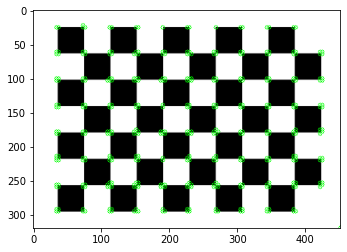

In [ ]:
harris(image, 2, 1)

comparer avec opencv

Same result pretty much, although in our attempt (even with the Moravec algorithm) the same corners are detected multiple times, I believe it is due to how small the 3x3 window is, as that allows the same corner to appear in multiple windows and thus detected multiple times, but overall, the result is the same

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


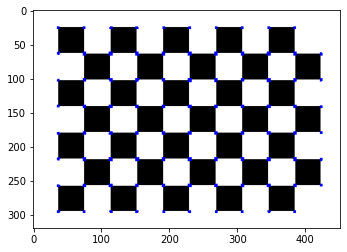

In [16]:
img=image.copy()
# Detecter les points avec Harris
dst = cv.cornerHarris(img,2,3,0.04)
# Dilater l'image pour mieux visualiser les points de coins
dst = cv.dilate(dst,None)
# Créer une image RVB
img2=np.zeros((img.shape[0],img.shape[1],3))
img2[:,:,0]=img
img2[:,:,1]=img
img2[:,:,2]=img
# Dessiner les points sur l'image RVB
img2[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(img2)

### Testing other images (our function vs openCV's)

In [ ]:
image_1 = cv.imread(path+'image1.png',0)
image_3 = cv.imread(path+'image3.jpg',0)
image_4 = cv.imread(path+'image4.jpg',0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


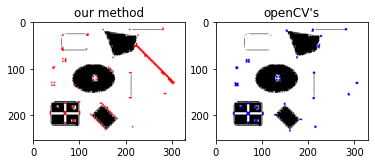

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


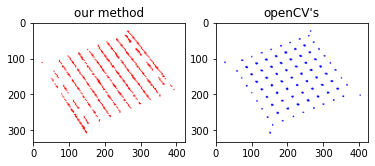

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


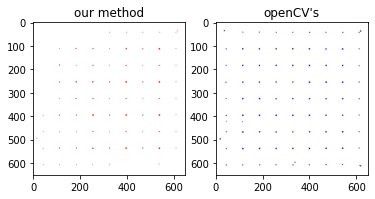

In [46]:
harris(image_1, seuil, 1)
harris(image_3, seuil, 1)
harris(image_4, seuil, 1)

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 10 Decembre 2021 à 23:00


In [ ]:
# bonne chance